# FX vol trading strategy - implementation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from arch import arch_model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

### Algorithm description (WIP..)

1) For a given trading pair, say USDRUB, fit the appropriate GARCH model for time t = 0 until time t = T
2) Standing at time T, forecast the 30-day volatility. If the forecast is above market pricing, enter long straddle, if below then enter a short straddle. If not signficantly different, do nothing. 

In [2]:
# Load return data
df = import_data(fx_pair='USDRUB')
df.dropna(inplace=True)
returns = df['log_ret'] * 100

# arch model
model = arch_model(returns, mean='AR', vol='GARCH', p=2,q=1, dist = 'Gaussian')


In [6]:
# Conditional volatility forecasting
vol_forecasts = get_rolling_vol_forecasts(return_series=returns, 
                                            model=model, 
                                            horizon=21,
                                            fitting_end_date="2021-01-01",
                                            )
vol_forecasts = vol_forecasts.multiply(np.sqrt(252))

df = df.merge(vol_forecasts['h.21'], left_index=True, right_index=True)
df.rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
df['cond_forecast_to_implied'] = df['cond_vol_forecast'] / df['v1m']
df

................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


..............

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.......................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


....................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.......

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.............

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


................

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for lines

.......

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


...

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


...........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


............

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.......

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


...............

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


......

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


..........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


..........

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.............

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,cond_vol_forecast,cond_forecast_to_implied
2021-01-01,16.3650,15.6350,14.565,74.4128,74.4000,74.4255,0.000000,0.000344,11.779561,0.719802
2021-01-04,16.3600,15.5050,14.400,74.3254,74.3127,74.3381,-0.001175,0.002751,10.957114,0.669750
2021-01-05,16.5800,15.5850,14.525,74.0237,74.0115,74.0359,-0.004067,0.003917,10.364928,0.625146
2021-01-06,16.0800,15.3950,14.435,73.9273,73.9202,73.9343,-0.001303,0.004170,9.644864,0.599805
2021-01-07,16.1150,15.4425,14.465,73.9273,73.9202,73.9343,0.000000,0.000522,8.959223,0.555956
...,...,...,...,...,...,...,...,...,...,...
2022-02-16,22.3250,20.4600,19.135,75.2695,75.2480,75.2910,-0.001288,0.016853,20.824827,0.932803
2022-02-17,25.6800,22.1175,19.895,76.3176,76.2880,76.3472,0.013829,0.001072,21.674371,0.844018
2022-02-18,26.5125,23.1300,20.575,77.3366,77.3102,77.3629,0.013264,0.006342,22.276862,0.840240
2022-02-21,34.2100,28.0900,22.885,79.7535,79.7120,79.7950,0.030773,0.021982,32.480373,0.949441


<AxesSubplot:>

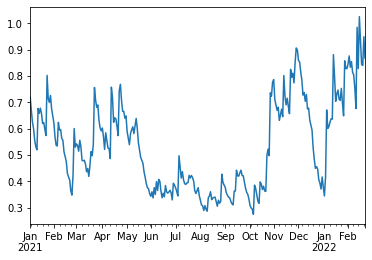

In [4]:
df['cond_forecast_to_implied'].plot()

In [7]:
threshold_up = 0.75
threshold_down = 0.35

df['direction'] = 0

conditions = [ 
    (df['cond_forecast_to_implied'] > threshold_up) , 
    (df['cond_forecast_to_implied'] < threshold_down) , 
    #(threshold_down <= df['cond_forecast_to_implied']) & (df['cond_forecast_to_implied'] <= threshold_up) 
    ]
directions = [1, -1]

df['direction'] = np.select(conditions, directions)


In [9]:
counter = 0 
df['direction_new'] = 0

for index, row in df.iterrows():
    
    if counter > 0 : 
        counter -= counter
        continue

    if row['cond_forecast_to_implied'] > threshold_up:
        row['direction_new'] = 1
        counter = 21

    if row['cond_forecast_to_implied'] < threshold_down:
        row['direction_new'] = -1
        counter = 21

df.tail(30)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,cond_vol_forecast,cond_forecast_to_implied,direction,direction_new
2022-01-12,15.2050,15.4650,15.5600,74.7175,74.7050,74.7300,0.003447,0.009421,9.674398,0.636264,0,0
2022-01-13,16.4900,16.3950,16.1775,76.3048,76.2700,76.3396,0.021022,0.026261,14.532004,0.881262,1,0
2022-01-14,16.8725,16.6900,16.3150,76.2402,76.2120,76.2684,-0.000847,0.024913,13.446806,0.796966,1,0
2022-01-17,17.7425,17.1550,16.6200,76.1035,76.0770,76.1300,-0.001795,0.019636,12.492817,0.704118,0,0
2022-01-18,18.0150,17.5500,17.1000,76.9664,76.9420,76.9909,0.011275,0.027891,13.185800,0.731935,0,0
2022-01-19,17.9125,17.5900,17.1500,76.2094,76.1947,76.2240,-0.009884,0.022141,13.379733,0.746950,0,0
2022-01-20,18.1275,17.5700,17.0850,76.6905,76.6810,76.7000,0.006293,0.029330,12.916805,0.712553,0,0
2022-01-21,18.7300,18.0550,17.3400,77.4677,77.4467,77.4886,0.010083,0.041654,13.255144,0.707696,0,0
2022-01-24,20.9650,19.7550,18.4000,78.7687,78.7404,78.7970,0.016655,0.050648,15.791922,0.753252,1,0
2022-01-25,20.9875,19.3950,18.1500,78.6506,78.6220,78.6792,-0.001500,0.051673,14.630590,0.697110,0,0
